In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, least_squares 
from tqdm import tqdm

In [2]:
##Import the excel file 
sensor_df = pd.read_csv('104.csv')

#Down sample to every 100
sensor_df_smol = sensor_df[0:100000:100]
sensor_df_smol.head()

,sensor ID,norm_secs (secs),time (days)
0,63802,0.000000,39416.607535
100,415483,4.500004,39416.607587
200,161919,9.000008,39416.607639
300,943442,12.500011,39416.607679
400,194738,16.500015,39416.607726


In [3]:
#filter to adjadent gateways with a time difference larger than 3 seconds
diff_sensor_df = sensor_df_smol.diff()
#print(diff_sensor_df[40:60])
#print(sensor_df_smol[40:60])
backbone_sensor_df = sensor_df_smol[diff_sensor_df['norm_secs (secs)'] > 3]
backbone_sensor_df.head()

,sensor ID,norm_secs (secs),time (days)
100,415483,4.500004,39416.607587
200,161919,9.000008,39416.607639
300,943442,12.500011,39416.607679
400,194738,16.500015,39416.607726
500,202164,20.000018,39416.607766


In [4]:
print(backbone_sensor_df.shape)
print(sensor_df_smol.shape)
print(backbone_sensor_df['sensor ID'].nunique())
print(backbone_sensor_df['sensor ID'].drop_duplicates())
gateway_ids = backbone_sensor_df['sensor ID'].drop_duplicates()
print(gateway_ids.iloc[10])
#print(backbone_sensor_df['sensor ID'][0:10])
print(backbone_sensor_df[9:11])
print(backbone_sensor_df.iloc[10,1])
test = np.linspace(100,1000,10,dtype=int)
#index = np.linspace(100,(num_gates-1)*100,num_gates-1,dtype=int)
#print(index)
print(test)
print((test//100))
print(backbone_sensor_df.iloc[10][0])

(23, 3)
(1000, 3)
15
100     415483
200     161919
300     943442
400     194738
500     202164
600     292567
700     333474
800     434898
1000    117554
1200    544844
1600    216898
1700    406748
2000    882682
2100    304380
2200    469168
Name: sensor ID, dtype: int64
216898
      sensor ID  norm_secs (secs)   time (days)
1000     117554         38.000034  39416.607975
1100     194738         41.500037  39416.608015
41.500036752881336
[ 100  200  300  400  500  600  700  800  900 1000]
[ 1  2  3  4  5  6  7  8  9 10]
194738.0


In [5]:
#function to check how many times gateways are next to each other and return average time 
def gateway_adjacent(gateway_x, gateway_y):
    #print(gateway_x)
    #print(gateway_y)
    
    count = 0
    time = 0
    size = backbone_sensor_df.shape[0]
    #print(size)
    for x in range(size):
        if (backbone_sensor_df.iloc[x][0] == gateway_x):
            #if it's the first index 
            if (x == 0):
                if (backbone_sensor_df.iloc[x+1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+1][1] - backbone_sensor_df.iloc[x][1])
            
            #if it's a last index
            elif (x == size-1):
                if (backbone_sensor_df.iloc[x-1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-1][1] - backbone_sensor_df.iloc[x][1])
            
            else:
                if (backbone_sensor_df.iloc[x+1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+1][1] - backbone_sensor_df.iloc[x][1])
                elif (backbone_sensor_df.iloc[x-1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-1][1] - backbone_sensor_df.iloc[x][1])
                    
    if (count >= 1): 
        return time/count
    else:
        return 0
    

In [137]:
#function to check total time between gateways and returns average time (5 hops)
def gateway_total(gateway_x, gateway_y):
    count = 0
    time = 0
    size = backbone_sensor_df.shape[0]
    
    hops = 11
    #TOD0: if the hops get too large we go out of range on the otherside. Fix this later
    
    for x in range(size):
        if (backbone_sensor_df.iloc[x][0] == gateway_x):
            #if it's the first indexes 
            if (x <= hops):
                for i in range(hops):
                    if (backbone_sensor_df.iloc[x+i][0] == gateway_y):
                        count += 1
                        time += abs(backbone_sensor_df.iloc[x+i][1] - backbone_sensor_df.iloc[x][1])
            
            #if it's in the last 5 index
            elif (x > size-hops):
                for i in range(hops):
                    if (backbone_sensor_df.iloc[x-i][0] == gateway_y):
                        count += 1
                        time += abs(backbone_sensor_df.iloc[x-i][1] - backbone_sensor_df.iloc[x][1])
            else:
                for i in range(hops):
                    #print(i)
                    #print(backbone_sensor_df.iloc[x+i][0])
                    #print(gateway_y)
                    if (backbone_sensor_df.iloc[x+i][0] == gateway_y):
                        count += 1
                        time += abs(backbone_sensor_df.iloc[x+i][1] - backbone_sensor_df.iloc[x][1])
                        #print('adding')
                    elif (backbone_sensor_df.iloc[x-i][0] == gateway_y):
                        count += 1
                        time += abs(backbone_sensor_df.iloc[x-i][1] - backbone_sensor_df.iloc[x][1])
                        #print('adding')
                       
                    
    if (count >= 1): 
        #print(count)
        return time/count
    else:
        return 0

In [138]:
#set up a matrix of time between adjacent gateways, this is a proxy for distance
num_gates = backbone_sensor_df['sensor ID'].nunique()
time_pairs = np.zeros((num_gates,num_gates))
gateway_ids = backbone_sensor_df['sensor ID'].drop_duplicates()

for x in tqdm(range(num_gates)):
    #times = []
    for y in range(num_gates):
        #find how many times x gateway is adjacent to y gateway 
        gateway_id_x = gateway_ids.iloc[y]
        gateway_id_y = gateway_ids.iloc[x]
        average = gateway_total(gateway_id_x,gateway_id_y)

        #add to time_pairs[x][y]
        time_pairs[x][y] = average
        
        
time_pairs

100%|██████████| 15/15 [00:00<00:00, 16.97it/s]


array([[ 0.        ,  0.        , 22.50001993, 15.00001328, 36.50003232,
        20.25001793, 29.50002613, 18.50001638, 18.50001638, 13.00001151,
         4.00000354, 17.5000155 , 18.00001594, 21.50001904, 24.5000217 ],
       [ 4.50000399,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [16.00001417, 14.25001262,  9.75000863, 21.50001904, 23.25002059,
        18.90001674, 16.25001439, 18.50001638, 14.50001284, 21.0000186 ,
        17.25001528, 24.33335488, 22.00001948, 25.50002258, 28.50002524],
       [21.33335223, 20.00001771, 17.5000155 ,  8.33334071, 21.50001904,
        19.33335046, 14.50001284, 18.50001638,  3.5000031 , 29.50002613,
        19.00001683, 22.50001993, 33.00002923, 36.50003232,  0.        ],
       [26.00002303, 11.00000974, 20.00001771,  3.5000031 ,  0.        ,
        29.00002568,  0.        ,  0.        , 

In [88]:
#get the average velocity from the ground truth data 
avg_vel = 2 #m/s

In [151]:
#calculate the distance matrix from the average time and average velocity 

distance = avg_vel*time_pairs
distance
print(distance.shape)

(15, 15)


In [186]:
#pick three gateways to triangulate from ground truth
#415483 16637.45912	25122.26386	12.6755825
#161919 16629.04516	25116.42995	14.75286457
#943442 16646.42446	25107.78124	14.95667207

gateway_a = [16637.45912,25122.26386]
gateway_b = [16629.04516,25116.42995]
gateway_c = [16646.42446,25107.78124]

#pick a gateway to try and find
#292567

print(gateway_ids)

d3 = distance[5][2]
d2 = distance[5][1]
d1 = distance[5][0]

x1 = gateway_a[0]
y1 = gateway_a[1]

x2 = gateway_b[0]
y2 = gateway_b[1]

x3 = gateway_c[0]
y3 = gateway_c[1]



100     415483
200     161919
300     943442
400     194738
500     202164
600     292567
700     333474
800     434898
1000    117554
1200    544844
1600    216898
1700    406748
2000    882682
2100    304380
2200    469168
Name: sensor ID, dtype: int64


In [164]:
np.array([5,6])

array([5, 6])

In [161]:
from sympy.solvers.solveset import nonlinsolve
from sympy import Symbol, nsolve, S
from scipy.optimize import fsolve, least_squares 
from scipy import optimize

d3 = distance[5][2]
d2 = distance[5][1]
d1 = distance[5][0]
x1 = gateway_a[0]
y1 = gateway_a[1]

x2 = gateway_b[0]
y2 = gateway_b[1]

x3 = gateway_c[0]
y3 = gateway_c[1]

def fun(initial):
    x = initial[0]
    y = initial[1]
    output = [ (x - x1)**2 + (y - y1)**2 - d1**2, (x - x2)**2 + (y - y2)**2 - d2**2] #, (x - x3)**2 + (y - y3)**2 - d3**2 ]
    return output

print(fsolve(fun,[20000,20000]))


[16603.71695341 25099.16918675]


In [168]:
#d np.linalg.norm([x1,y1],[x2,y2])

def fun(point):
    x = point[0]
    y = point[1]
    error1 = np.linalg.norm(np.array([x,y])-np.array([x1,y1])) - d1
    error2 = np.linalg.norm(np.array([x,y])-np.array([x2,y2])) - d2
    error3 = np.linalg.norm(np.array([x,y])-np.array([x3,y3])) - d3
    error_total = error1 + error2 + error3
    
    return error_total 
    
least_squares(fun,[16000,25000])

 active_mask: array([0., 0.])
        cost: 2.9290930549923318e-08
         fun: array([0.00024204])
        grad: array([0.00069484, 0.00014075])
         jac: array([[2.87079216, 0.58153818]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 32
        njev: 12
  optimality: 0.0006948376352900371
      status: 3
     success: True
           x: array([16671.91366122, 25121.65668275])

In [213]:
#for each gateway get the location 

positions_x = []
positions_y = []

#loop through gateways 
for i in range(len(gateway_ids)):
    gateway = gateway_ids.iloc[i]
    d1 = distance[i][0]
    d2 = distance[i][1]
    d3 = distance[i][2]
    
    def fun(point):
        x = point[0]
        y = point[1]
        error1 = np.linalg.norm(np.array([x,y])-np.array([x1,y1])) - d1
        error2 = np.linalg.norm(np.array([x,y])-np.array([x2,y2])) - d2
        error3 = np.linalg.norm(np.array([x,y])-np.array([x3,y3])) - d3
        error_total = error1 + error2 + error3

        return error_total 
    
    #print(gateway)
    #print(least_squares(fun,[16000,25000]).x)
    #positions.append([gateway,least_squares(fun,[16000,25000]).x])
    positions_x.append(least_squares(fun,[16000,25000]).x[0])
    positions_y.append(least_squares(fun,[16000,25000]).x[1])

zipped = list(zip(gateway_ids,positions_x,positions_y))
positions = pd.DataFrame(zipped, columns = ['gateway_ids','positions_x','positions_y'])
positions.head()

,gateway_ids,positions_x,positions_y
0,415483,16650.530496,25115.588363
1,161919,16636.308973,25118.245111
2,943442,16662.837424,25120.128100
3,194738,16675.585655,25122.396410
4,202164,16674.363606,25122.150238


In [221]:
##Import the excel file 
truth_df = pd.read_csv('sensors.csv')
truth_df.head()

gateway_ids

#get the ground truth values for the gateway ids of interest
truth_df_filtered = truth_df[truth_df['sensor ID'].isin(gateway_ids.values)]
truth_df_filtered.head()

,sensor ID,x (m),y (m),radius (m)
117554,117554,16644.599135,25112.587220,11.550329
161919,161919,16629.045160,25116.429953,14.752865
194738,194738,16641.888262,25105.808890,13.792462
202164,202164,16626.574299,25109.527273,11.858802
216898,216898,16644.516358,25100.415618,14.281532


In [219]:
#get gateway_id position error 

error = np.zeros(15)
for i in range(len(gateway_ids)):
    gateway = gateway_ids.iloc[i]
    truth_data = truth_df[truth_df['sensor ID'] == gateway]
    x = truth_data['x (m)'].values
    y = truth_data['y (m)'].values
    
    position_data = positions[positions['gateway_ids'] == gateway]
    x_est = position_data['positions_x'].values
    y_est = position_data['positions_y'].values
    
    error[i] = np.linalg.norm(np.array([x,y])-np.array([x_est,y_est]))
    
print(error)

[14.67729319  7.48717424 20.53850589 37.5587553  49.42830233 32.8736562
 43.87000832 44.5729841  39.80152814 41.6336658  19.5779098  13.5126341
 20.59968509  7.09894182 15.52573067]


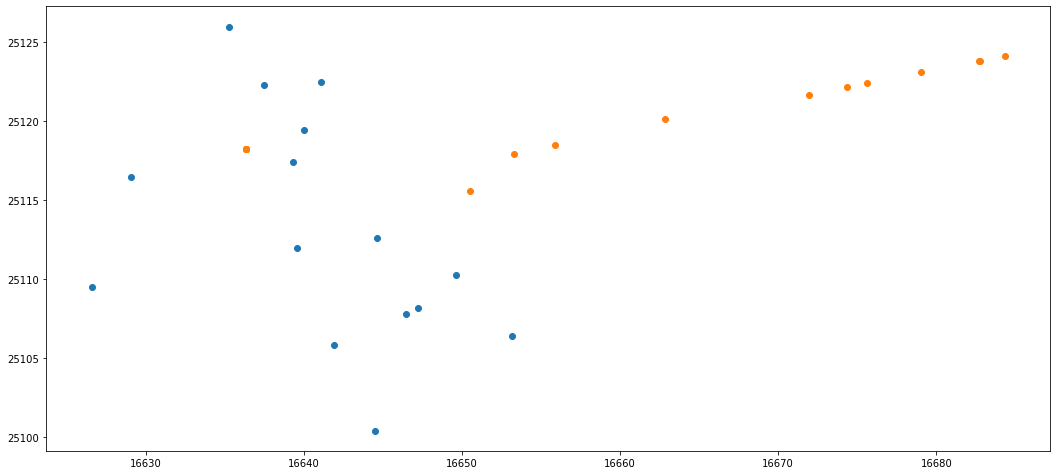

In [227]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
plt.scatter(truth_df_filtered["x (m)"], truth_df_filtered["y (m)"])
plt.scatter(positions['positions_x'], positions['positions_y'])
plt.show()

In [ ]:
#plot the gateways 

In [ ]:
#compare gateway locations to ground truth 

In [ ]:
#bring in other sensor traces 
#figure out your for loopin problem 

In [ ]:
#OLD STUFF 

#truth_df.loc(truth_df['sensor ID'].isin(gateway_ids.values))


from sympy.solvers.solveset import nonlinsolve
from sympy import Symbol, nsolve, S
from scipy.optimize import fsolve 
from scipy import optimize 

d3 = S(str(distance[5][2]))
d2 = S(str(distance[5][1]))
d1 = S(str(distance[5][0]))
x1 = S(str(gateway_a[0]))
y1 = S(str(gateway_a[1]))

x2 = S(str(gateway_b[0]))
y2 = S(str(gateway_b[1]))

x3 = S(str(gateway_c[0]))
y3 = S(str(gateway_c[1]))



#derive other distances from the three sensors
x0 = Symbol('x0')
y0 = Symbol('y0')
f1 = (x0 - x1)**2 + (y0 - y1)**2 - d1**2
f2 = (x0 - x2)**2 + (y0 - y2)**2 - d2**2
f3 = (x0 - x3)**2 + (y0 - y3)**2 - d3**2

print(f1)
print(f2)
print(f3)

print(nonlinsolve((f1,f2),(x0,y0)))

#backbone_sensor_df = sensor_df.loc(sensor_df['norm_secs (secs)'].diff() > 1)
#print(backbone_sensor_df)
#print(sensor_df.filter(sensor_df['norm_secs (secs)'].diff() > 1))
#backbone_sensor_df = sensor_df_smol.loc(diff_sensor_df['norm_secs (secs)'] > 1.0)
#backbone_sensor_df.head()

#print(sensor_df_smol[diff_sensor_df['norm_secs (secs)'] > 3])

##print(sensor_df['norm_secs (secs)'][100:110])
#print(sensor_df["sensor ID"][0])

#Get a pairwise matrix for the backbone gateways
num_gates = backbone_sensor_df.shape[0]
index = np.linspace(100,(num_gates-1)*100,num_gates-1,dtype=int)

#set up a matrix of time between gateways, this is a proxy for distance
time_pairs = np.ones((num_gates,num_gates))

for x in index:
    times = []
    for y in index:
        #get all the pairs
        if (backbone_sensor_df["sensor ID"][x+100] == backbone_sensor_df["sensor ID"][y]):
            times.append(abs(backbone_sensor_df["norm_secs (secs)"][x+100] - backbone_sensor_df["norm_secs (secs)"][y]))
        
        #set the distance values
        pairs[(x//100)-1][(y//100)-1] = np.mean(times)
        
#pairs

#if (backbone_sensor_df.iloc[x][1] == backbone_sensor_df.iloc[y][1]):

        #times.append(abs(backbone_sensor_df.iloc[x][1] == backbone_sensor_df.iloc[y][1]))
        #time_pairs[x][y] = abs(backbone_sensor_df.iloc[x][1] - backbone_sensor_df.iloc[y][1])
    #set the values
    #timenp.mean(times)
    
                
                if (backbone_sensor_df.iloc[x+1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+1][1] - backbone_sensor_df.iloc[x][1])
                elif (backbone_sensor_df.iloc[x-1][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-1][1] - backbone_sensor_df.iloc[x][1])
                # +/- 2
                elif (backbone_sensor_df.iloc[x+2][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+2][1] - backbone_sensor_df.iloc[x][1])
                elif (backbone_sensor_df.iloc[x-2][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-2][1] - backbone_sensor_df.iloc[x][1])
                elif (backbone_sensor_df.iloc[x+3][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+3][1] - backbone_sensor_df.iloc[x][1])
                elif (backbone_sensor_df.iloc[x-3][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-3][1] - backbone_sensor_df.iloc[x][1])
                    
                elif (backbone_sensor_df.iloc[x+4][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+4][1] - backbone_sensor_df.iloc[x][1])
                elif (backbone_sensor_df.iloc[x-4][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-4][1] - backbone_sensor_df.iloc[x][1])

                elif (backbone_sensor_df.iloc[x+5][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x+5][1] - backbone_sensor_df.iloc[x][1])
                elif (backbone_sensor_df.iloc[x-5][0] == gateway_y):
                    count += 1
                    time += abs(backbone_sensor_df.iloc[x-5][1] - backbone_sensor_df.iloc[x][1])
                    
                    
    """"
    def fun(initial):
        x = initial[0]
        y = initial[1]
        output = [ (x - x1)**2 + (y - y1)**2 - d1**2, (x - x2)**2 + (y - y2)**2 - d2**2] #, (x - x3)**2 + (y - y3)**2 - d3**2 ]
        return output

    print(fsolve(fun,[20000,20000]))"""